[conv] 1/15:   0%|          | 0/291 [00:00<?, ?it/s]

→ conv epoch 1: val loss=7.066 acc=0.128


[conv] 2/15:   0%|          | 0/291 [00:00<?, ?it/s]

→ conv epoch 2: val loss=6.598 acc=0.156


[conv] 3/15:   0%|          | 0/291 [00:00<?, ?it/s]

→ conv epoch 3: val loss=6.371 acc=0.168


[conv] 4/15:   0%|          | 0/291 [00:00<?, ?it/s]

→ conv epoch 4: val loss=6.234 acc=0.176


[conv] 5/15:   0%|          | 0/291 [00:00<?, ?it/s]

→ conv epoch 5: val loss=6.142 acc=0.182


[conv] 6/15:   0%|          | 0/291 [00:00<?, ?it/s]

→ conv epoch 6: val loss=6.085 acc=0.185


[conv] 7/15:   0%|          | 0/291 [00:00<?, ?it/s]

→ conv epoch 7: val loss=6.043 acc=0.189


[conv] 8/15:   0%|          | 0/291 [00:00<?, ?it/s]

→ conv epoch 8: val loss=6.021 acc=0.191


[conv] 9/15:   0%|          | 0/291 [00:00<?, ?it/s]

→ conv epoch 9: val loss=6.011 acc=0.193


[conv] 10/15:   0%|          | 0/291 [00:00<?, ?it/s]

→ conv epoch 10: val loss=5.991 acc=0.194


[conv] 11/15:   0%|          | 0/291 [00:00<?, ?it/s]

→ conv epoch 11: val loss=5.988 acc=0.195


[conv] 12/15:   0%|          | 0/291 [00:00<?, ?it/s]

→ conv epoch 12: val loss=5.983 acc=0.195


[conv] 13/15:   0%|          | 0/291 [00:00<?, ?it/s]

→ conv epoch 13: val loss=5.981 acc=0.196


[conv] 14/15:   0%|          | 0/291 [00:00<?, ?it/s]

→ conv epoch 14: val loss=5.979 acc=0.196


[conv] 15/15:   0%|          | 0/291 [00:00<?, ?it/s]

→ conv epoch 15: val loss=5.979 acc=0.196


[attn] 1/15:   0%|          | 0/291 [00:00<?, ?it/s]

→ attn epoch 1: val loss=7.493 acc=0.052


[attn] 2/15:   0%|          | 0/291 [00:00<?, ?it/s]

→ attn epoch 2: val loss=7.281 acc=0.076


[attn] 3/15:   0%|          | 0/291 [00:00<?, ?it/s]

→ attn epoch 3: val loss=6.654 acc=0.139


[attn] 4/15:   0%|          | 0/291 [00:00<?, ?it/s]

→ attn epoch 4: val loss=6.419 acc=0.157


[attn] 5/15:   0%|          | 0/291 [00:00<?, ?it/s]

→ attn epoch 5: val loss=6.306 acc=0.166


[attn] 6/15:   0%|          | 0/291 [00:00<?, ?it/s]

→ attn epoch 6: val loss=6.242 acc=0.170


[attn] 7/15:   0%|          | 0/291 [00:00<?, ?it/s]

→ attn epoch 7: val loss=6.192 acc=0.174


[attn] 8/15:   0%|          | 0/291 [00:00<?, ?it/s]

→ attn epoch 8: val loss=6.155 acc=0.177


[attn] 9/15:   0%|          | 0/291 [00:00<?, ?it/s]

→ attn epoch 9: val loss=6.136 acc=0.179


[attn] 10/15:   0%|          | 0/291 [00:00<?, ?it/s]

→ attn epoch 10: val loss=6.121 acc=0.180


[attn] 11/15:   0%|          | 0/291 [00:00<?, ?it/s]

→ attn epoch 11: val loss=6.112 acc=0.182


[attn] 12/15:   0%|          | 0/291 [00:00<?, ?it/s]

→ attn epoch 12: val loss=6.107 acc=0.183


[attn] 13/15:   0%|          | 0/291 [00:00<?, ?it/s]

→ attn epoch 13: val loss=6.100 acc=0.183


[attn] 14/15:   0%|          | 0/291 [00:00<?, ?it/s]

→ attn epoch 14: val loss=6.099 acc=0.183


[attn] 15/15:   0%|          | 0/291 [00:00<?, ?it/s]

→ attn epoch 15: val loss=6.099 acc=0.183

FINAL METRICS
Model           Loss    Accuracy
Conv‑Attn      5.979       0.196
Attn‑Attn      6.099       0.183


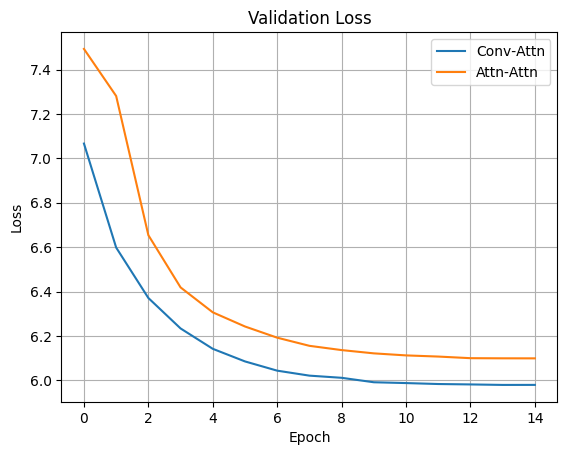

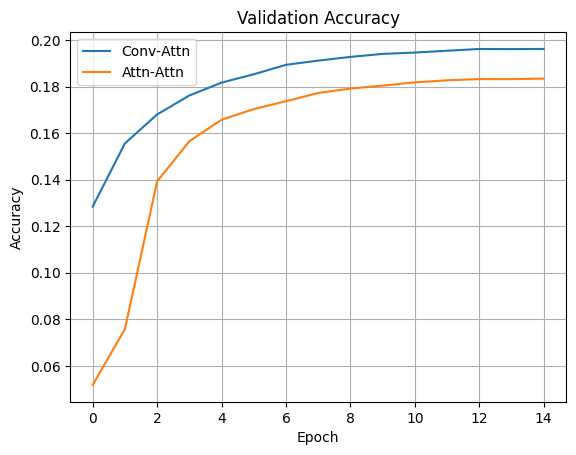

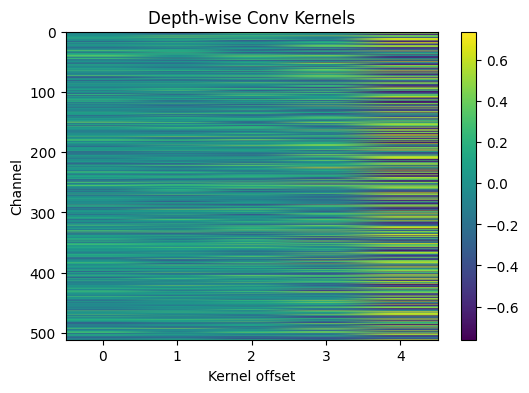

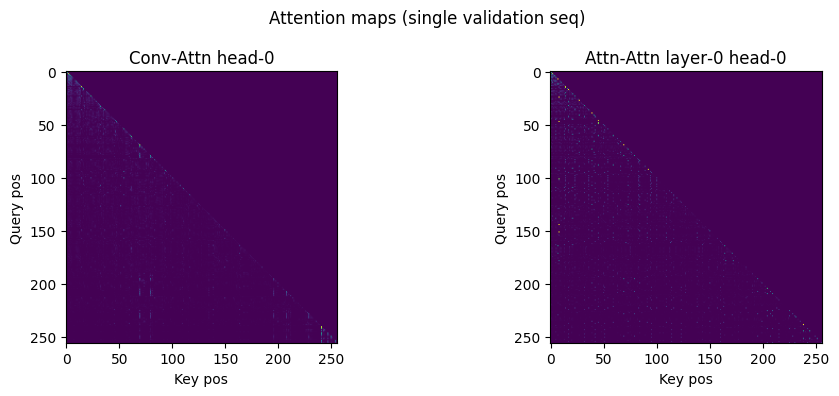

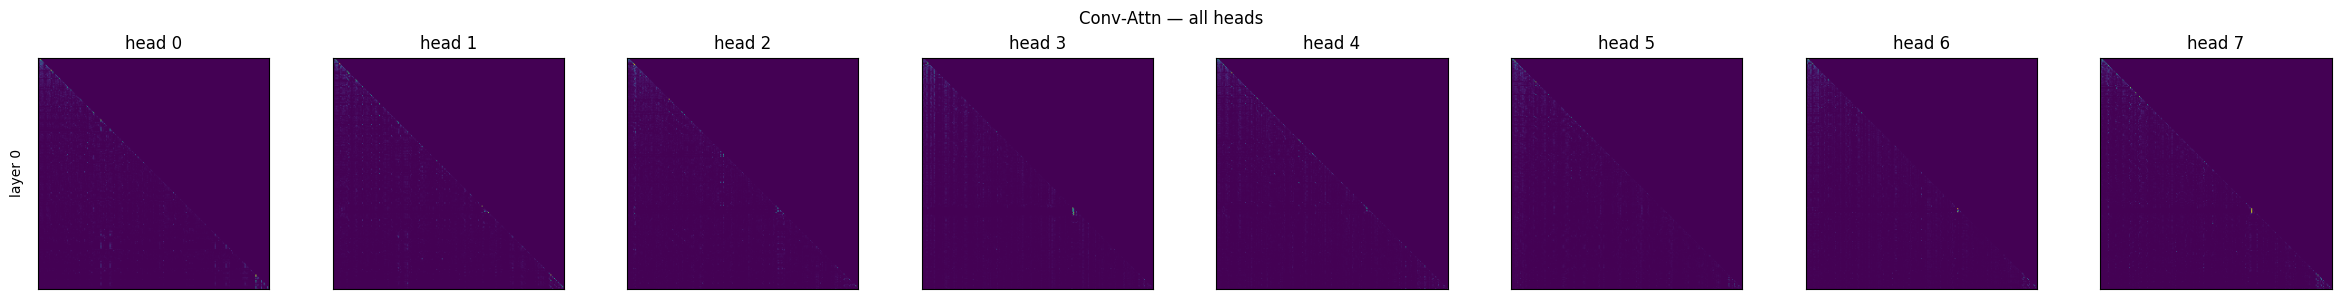

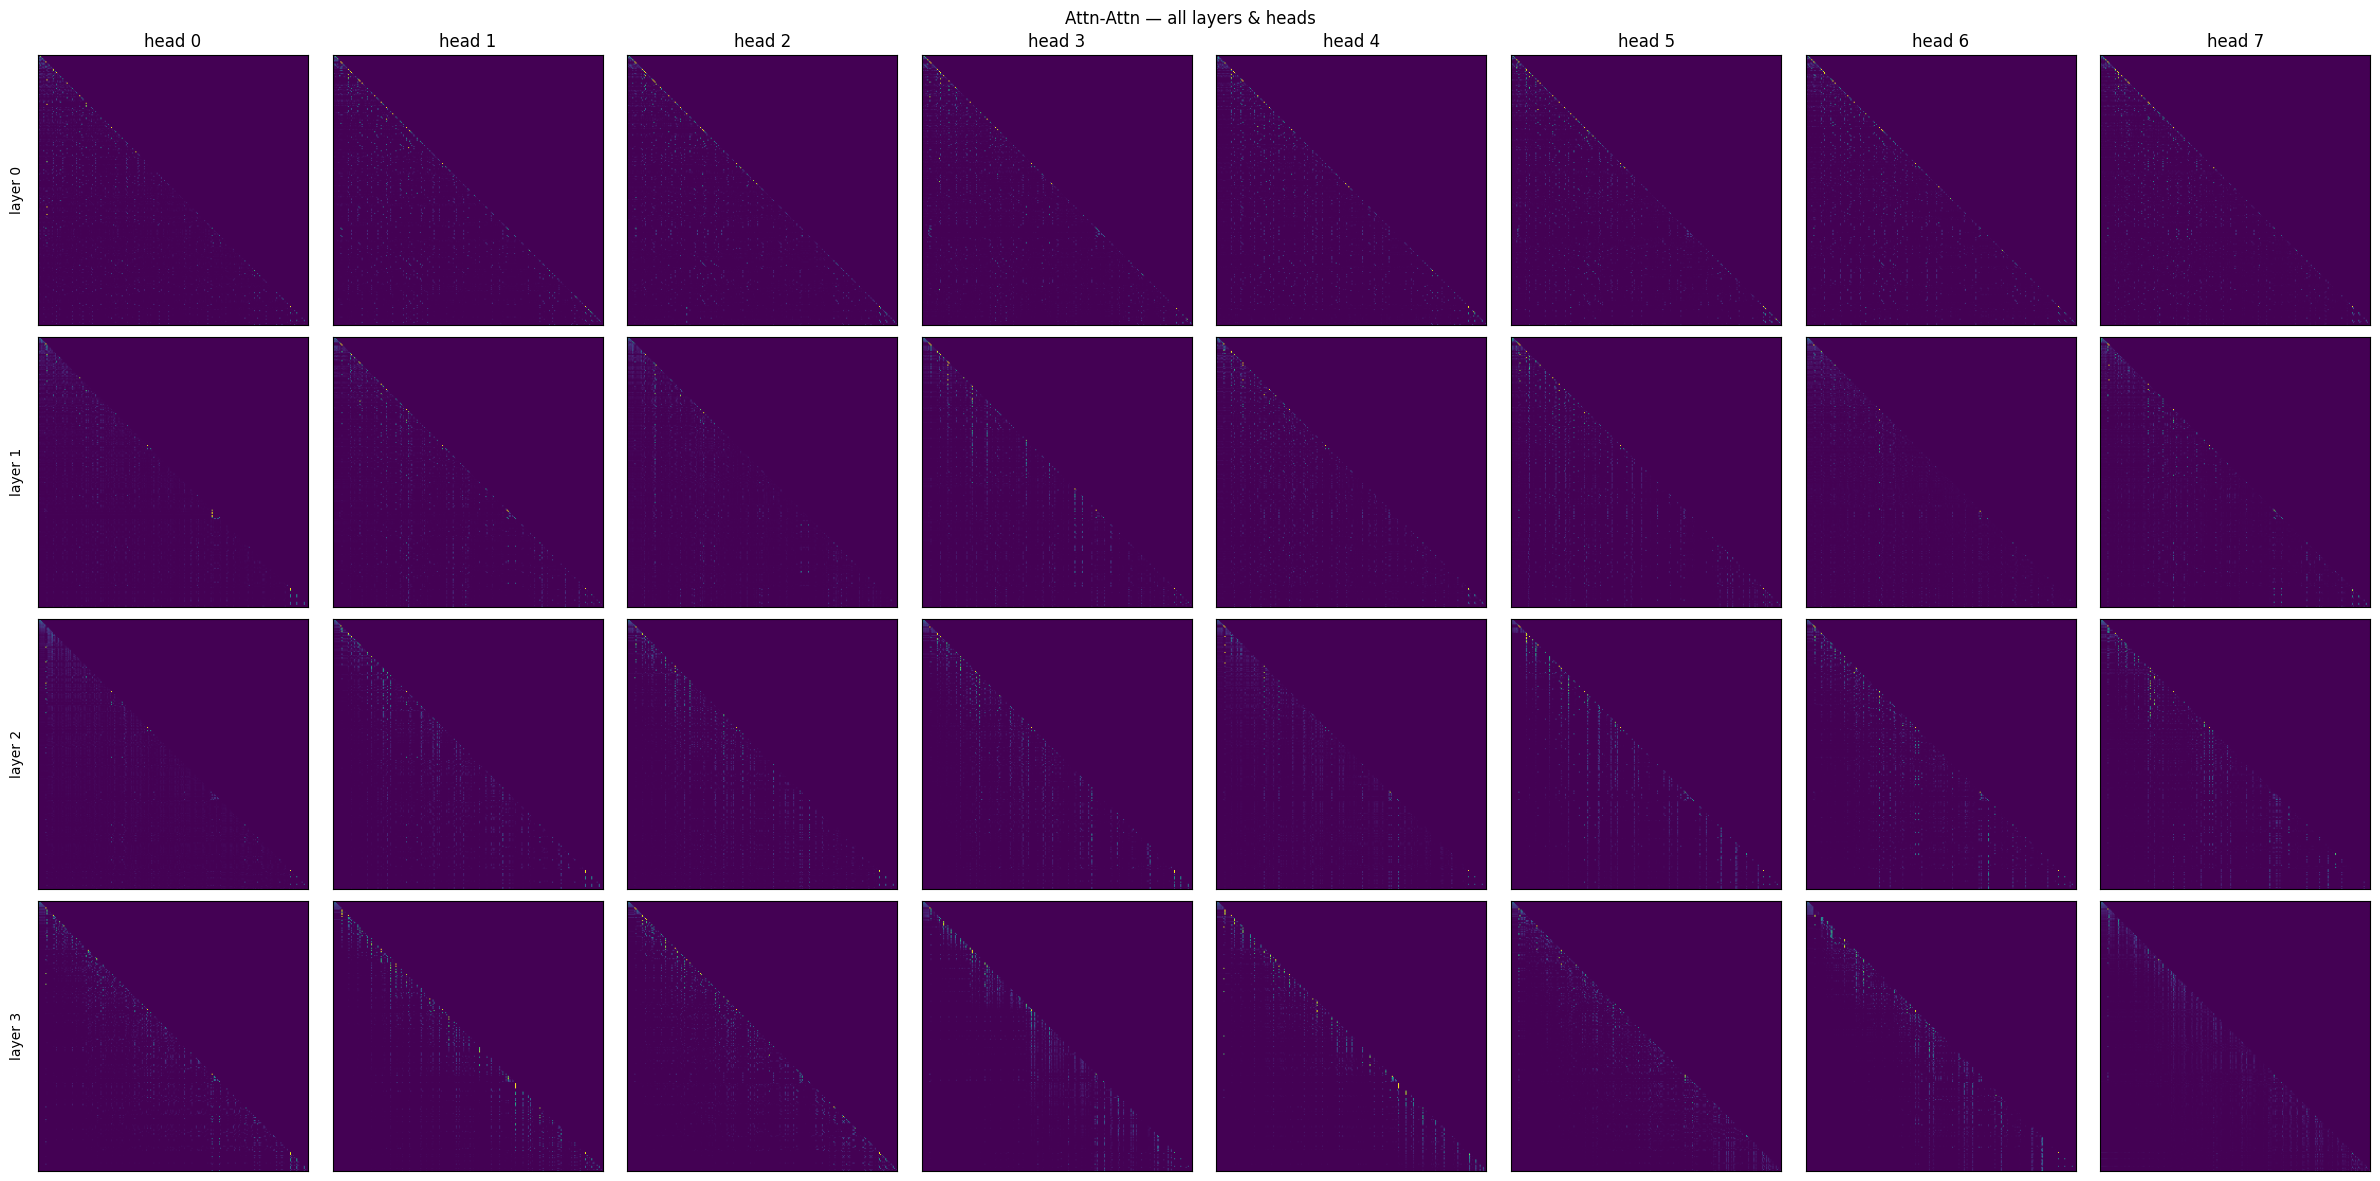

In [1]:
import torch, torch.nn as nn, torch.cuda.amp as amp
from torch.nn import functional as F
from torch.utils.data import DataLoader
from transformers import AutoTokenizer, get_cosine_schedule_with_warmup
from datasets import load_dataset
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import random, os, json, warnings; warnings.filterwarnings("ignore")

#Конфигурация
CFG = dict(
    dataset        = "wikitext",          # может быть попробую "roneneldan/TinyStories"
    wikitext_cfg   = "wikitext-2-raw-v1",
    seq_len        = 256,
    batch_size     = 32,
    epochs         = 15,
    d_model        = 512,
    n_heads        = 8,
    n_layers_attn  = 4,
    kernel_size    = 5,
    lr             = 3e-4,
    warmup_steps   = 500,
    grad_clip      = 1.0,
    mixed_precision= True,
    seed           = 42,
    out_dir        = "./hw1_runs"
)

os.makedirs(CFG["out_dir"], exist_ok=True)
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
random.seed(CFG["seed"]); torch.manual_seed(CFG["seed"])

#Датасет
tok = AutoTokenizer.from_pretrained("gpt2"); tok.pad_token = tok.eos_token
def build_loader(split:str):
    ds = load_dataset("wikitext", CFG["wikitext_cfg"], split=split) \
         if CFG["dataset"] == "wikitext" else load_dataset(CFG["dataset"], split=split)
    ids = [t for ex in ds for t in tok(ex["text"]).input_ids]
    S = CFG["seq_len"]
    seqs = [ids[i:i+S+1] for i in range(0, len(ids)-S-1, S)]
    x = torch.tensor([s[:-1] for s in seqs]); y = torch.tensor([s[1:] for s in seqs])
    return DataLoader(list(zip(x, y)), batch_size=CFG["batch_size"],
                      shuffle=(split == "train"), drop_last=True)

train_loader = build_loader("train")
val_loader   = build_loader("validation")
vocab_size   = tok.vocab_size

#Модели
class ConvAttnLM(nn.Module):
    def __init__(self):
        super().__init__()
        D,K,H = CFG["d_model"], CFG["kernel_size"], CFG["n_heads"]
        self.embed = nn.Embedding(vocab_size, D)
        self.conv  = nn.Conv1d(D, D, K, padding=K-1, groups=D)
        self.attn  = nn.MultiheadAttention(D, H, batch_first=True)
        self.norm  = nn.LayerNorm(D)
        self.proj  = nn.Linear(D, vocab_size)
    def forward(self, x, y=None, return_attn=False):
        h = self.embed(x)
        h = self.conv(h.transpose(1,2))[...,:x.size(1)].transpose(1,2)
        mask = torch.triu(torch.ones(x.size(1), x.size(1), device=x.device), 1).bool()
        h, att = self.attn(h, h, h, attn_mask=mask,
                           need_weights=return_attn, average_attn_weights=False)
        logits = self.proj(self.norm(h))
        loss = F.cross_entropy(logits.view(-1, vocab_size), y.view(-1)) if y is not None else None
        return (logits, loss, att) if return_attn else (logits, loss)

class AttnAttnLM(nn.Module):
    def __init__(self):
        super().__init__()
        D,H,L = CFG["d_model"], CFG["n_heads"], CFG["n_layers_attn"]
        self.embed = nn.Embedding(vocab_size, D)
        self.blocks = nn.ModuleList([nn.MultiheadAttention(D, H, batch_first=True) for _ in range(L)])
        self.norm  = nn.LayerNorm(D);  self.proj = nn.Linear(D, vocab_size)
    def forward(self, x, y=None, return_attn=False):
        h = self.embed(x)
        mask = torch.triu(torch.ones(x.size(1), x.size(1), device=x.device), 1).bool()
        atts = []
        for blk in self.blocks:
            h, att = blk(h, h, h, attn_mask=mask,
                         need_weights=return_attn, average_attn_weights=False)
            if return_attn: atts.append(att)
        logits = self.proj(self.norm(h))
        loss = F.cross_entropy(logits.view(-1, vocab_size), y.view(-1)) if y is not None else None
        return (logits, loss, atts) if return_attn else (logits, loss)

#Обучение и валидация
def run(model, name):
    model.to(DEVICE)
    opt = torch.optim.AdamW(model.parameters(), lr=CFG["lr"])
    sched = get_cosine_schedule_with_warmup(opt, CFG["warmup_steps"],
                                            len(train_loader)*CFG["epochs"])
    scaler = amp.GradScaler(enabled=CFG["mixed_precision"])
    hist = {"loss": [], "acc": []}

    for epoch in range(1, CFG["epochs"]+1):
        model.train(); total = 0; steps = 0
        pbar = tqdm(train_loader, desc=f"{name} {epoch}/{CFG['epochs']}")
        for x,y in pbar:
            x,y = x.to(DEVICE), y.to(DEVICE)
            with amp.autocast(enabled=CFG["mixed_precision"]):
                _, loss = model(x,y)
            scaler.scale(loss).backward()
            scaler.unscale_(opt); nn.utils.clip_grad_norm_(model.parameters(), CFG["grad_clip"])
            scaler.step(opt); scaler.update(); opt.zero_grad(); sched.step()
            total += loss.item(); steps += 1
            pbar.set_postfix(loss=f"{total/steps:.3f}")

        model.eval(); val_loss = corr = tok = 0
        with torch.no_grad():
            for x,y in val_loader:
                x,y = x.to(DEVICE), y.to(DEVICE)
                logits, l = model(x,y)
                val_loss += l.item()
                corr += (logits.argmax(-1) == y).sum().item(); tok += y.numel()
        hist["loss"].append(val_loss/len(val_loader))
        hist["acc"].append(corr/tok)
        print(f"→ {name} | val_loss={hist['loss'][-1]:.3f} acc={hist['acc'][-1]:.3f}")
        torch.save(model.state_dict(), f"{CFG['out_dir']}/{name}_ep{epoch}.pt")
    json.dump(hist, open(f"{CFG['out_dir']}/{name}_hist.json","w"))
    return hist, model

hist_conv, conv_model = run(ConvAttnLM(), "conv")
hist_attn, attn_model = run(AttnAttnLM(), "attn")

#Итоговые метрики
print("\nFINAL METRICS")
print(f"{'Model':<10}{'Loss':>10}{'Accuracy':>12}")
print(f"{'Conv‑Attn':<10}{hist_conv['loss'][-1]:>10.3f}{hist_conv['acc'][-1]:>12.3f}")
print(f"{'Attn‑Attn':<10}{hist_attn['loss'][-1]:>10.3f}{hist_attn['acc'][-1]:>12.3f}")

#loss/accuracy
def plot(metric, ylabel):
    plt.figure()
    plt.plot(hist_conv[metric], label="Conv‑Attn")
    plt.plot(hist_attn[metric], label="Attn‑Attn")
    plt.xlabel("Epoch"); plt.ylabel(ylabel); plt.title(f"Validation {ylabel}")
    plt.legend(); plt.grid(); plt.show()
plot("loss", "Loss"); plot("acc", "Accuracy")

#Ядра свёртки
kern = conv_model.conv.weight.detach().cpu().squeeze()
plt.figure(figsize=(6,4)); plt.imshow(kern, aspect="auto")
plt.colorbar(); plt.title("Depth‑wise Conv Kernels")
plt.xlabel("Kernel offset"); plt.ylabel("Channel"); plt.show()

#Карты
sample,_ = next(iter(val_loader)); sample = sample[:1].to(DEVICE)
_,_, att_conv = conv_model(sample, return_attn=True)
_,_, att_attn = attn_model(sample, return_attn=True)
conv_map = att_conv[0,0].detach().cpu()
attn_map = att_attn[0][0,0].detach().cpu()

fig, axs = plt.subplots(1,2, figsize=(10,4))
axs[0].imshow(conv_map); axs[0].set_title("Conv‑Attn head‑0")
axs[1].imshow(attn_map); axs[1].set_title("Attn‑Attn layer‑0 head‑0")
for ax in axs: ax.set_xlabel("Key pos"); ax.set_ylabel("Query pos")
plt.suptitle("Attention maps (single sequence)"); plt.tight_layout(); plt.show()

#Сетка для всех
def show_grid(model, sample, title=""):
    _,_, att = model(sample, return_attn=True)
    if isinstance(att, torch.Tensor): att = [att]
    L,H = len(att), att[0].shape[1]
    fig,axs = plt.subplots(L,H, figsize=(3*H,3*L), squeeze=False)
    for i in range(L):
        for h in range(H):
            axs[i][h].imshow(att[i][0,h].detach().cpu())
            axs[i][h].set_xticks([]); axs[i][h].set_yticks([])
            if i==0: axs[i][h].set_title(f"head {h}")
        axs[i][0].set_ylabel(f"layer {i}", rotation=90)
    plt.suptitle(title); plt.tight_layout(); plt.show()

show_grid(conv_model, sample, "Conv‑Attn — all heads")
show_grid(attn_model, sample, "Attn‑Attn — all layers & heads")

In [2]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 23.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 16.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 17.5 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2024.12.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which 